# N couches
# Alexis Araujo

In [69]:
from PIL import Image
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
#!pip install h5py
#from utilities import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import h5py
import glob
# import cv2

## Importation du dataSet

In [70]:
dataset_train = "../datasets/train_set.hdf5"
dataset_test = "../datasets/test_set.hdf5"

#on load le dataset d'entrainement
dataset = h5py.File(dataset_train, "r")

x_train = np.array(dataset["X"][:])
y_train = np.array(dataset["y"][:])

#on load le dataset de test
dataset = h5py.File(dataset_test, "r")

x_test = np.array(dataset["X"][:])
y_test = np.array(dataset["y"][:])

In [71]:
#x_train, x_test, y_train, y_test  = load_data_train()

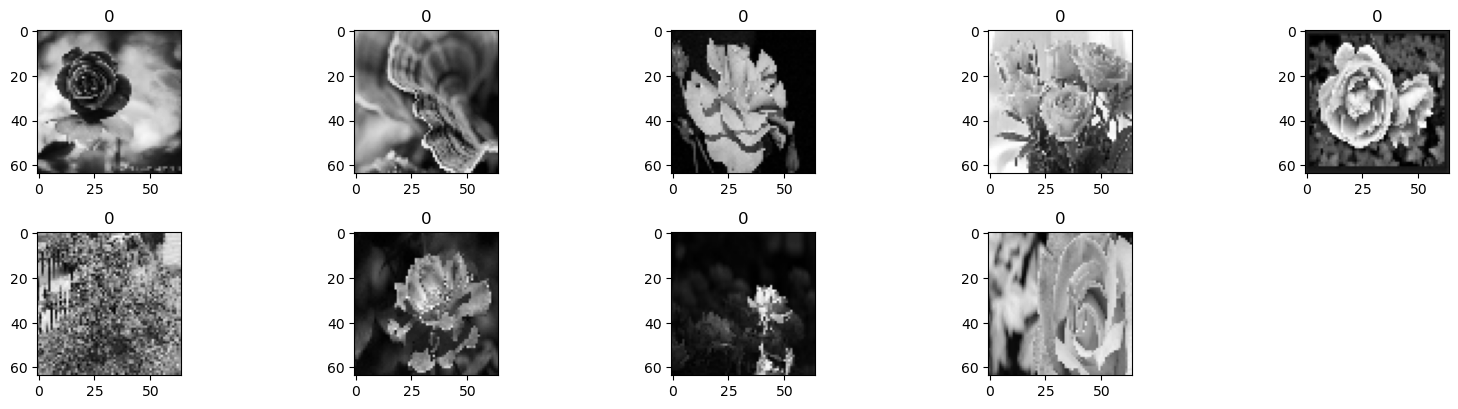

In [72]:
# Création d'une figure
plt.figure(figsize=(16, 8))

# Une boucle sur les 9 premières images et leurs étiquettes pour les afficher
for i in range(1, 10):
    plt.subplot(4, 5, i)  # sous graphique
    plt.imshow(x_train[i], cmap='gray')  # Affiche l'image (x_train[i])
    plt.title(y_train[i])  # Ajoute le titre du sous graphique en affichant les étiquettes
    plt.tight_layout()  # Ajustement
plt.show()

In [73]:
# Afficher les dimensions des données d'entrainement et des étiquettes
print(x_train.shape)
y_train = y_train.reshape(1, y_train.shape[0])
print(y_train.shape)
# Utilisation de np.unique avec return_counts=True pour obtenir les valeurs uniques et leurs occurrences dans y_train
print(np.unique(y_train, return_counts=True))
#print(y_train == 0, y_train == 1)

(2840, 64, 64)
(1, 2840)
(array([0, 1]), array([1420, 1420], dtype=int64))


In [74]:
# Affiche les dimensions des données de test et des étiquettes
print(x_test.shape)
y_test = y_test.reshape(1, y_test.shape[0])
print(y_test.shape)
# Utilisation de np.unique avec return_counts=True pour obtenir les valeurs uniques et leurs occurrences dans y_test
print(np.unique(y_test, return_counts=True))
#print(y_test == 0, y_test == 1)

(708, 64, 64)
(1, 708)
(array([0, 1]), array([354, 354], dtype=int64))


In [75]:
# y_train = y_train.T
# y_test = y_test.T

In [76]:
# Réorganise les données d'entrainement x_train pour qu'elles soient de forme (nombre d'échantillons, -1)
# et divise toutes les valeurs par la valeur maximale de x_train pour normaliser les données.
x_train = x_train.T
x_train_reshape = x_train.reshape(-1, x_train.shape[-1]) / x_train.max()

In [77]:
# Calcule la valeur maximale dans les données d'entrainement x_train_reshape après la transformation et la normalisation.
x_train_reshape.max()

1.0

In [78]:
# Réorganise les données d'entrainement x_test pour qu'elles soient de forme (nombre d'échantillons, -1)
# et divise toutes les valeurs par la valeur maximale de x_train pour normaliser les données.
x_test = x_test.T
x_test_reshape = x_test.reshape(-1, x_test.shape[-1]) / x_train.max()

In [79]:
# Calcule la valeur maximale dans les données d'entrainement x_test_reshape après la transformation et la normalisation.
x_test_reshape.max()

1.0

In [80]:
# m_train = 300
# m_test = 80
# x_test_reshape = x_test_reshape[:, :m_test]
# x_train_reshape = x_train_reshape[:, :m_train]
# y_train = y_train[:, :m_train]
# y_test = y_test[:, :m_test]

In [81]:
# Affiche la dimension des données d'entraînement x_train_reshape après la transformation et la normalisation.
print(x_train_reshape.shape)
# Affiche la dimension des données d'entraînement x_test_reshape après la transformation et la normalisation.
print(x_test_reshape.shape)

(4096, 2840)
(4096, 708)


In [82]:
print(y_train.shape)
print(y_test.shape)

(1, 2840)
(1, 708)


In [83]:
# Initialisation des paramètres du modèle
def initialisation(dimensions):
    parametres = {}
    C = len(dimensions)

    for c in range(1, C):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c - 1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)

    return parametres

In [84]:
# parametres = initialisation([2, 32, 32, 1])
#
# for key, val in parametres.items():
#     print(key, val.shape)

In [85]:
#Calcule la sortie d'un modèle basé sur une combinaison linéaire des caractéristiques d'entrée X avec des poids W et un biais b, suivi de l'application de la fonction sigmoïde.
def forward_propagation(X, parametres):
    activations = {'A0': X}

    C = len(parametres) // 2

    for c in range(1, C + 1):
        Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
        activations['A' + str(c)] = 1 / (1 + np.exp(-Z))

    return activations

In [86]:
# activations = forward_propagation(x_train, parametres)
#
# for key, val in activations.items():
#     print(key, val.shape)

In [87]:
# Régression logisitique
# Calcul du coût (la perte)
def logLoss(A, y):  # Ai est la probabilité prédite par le modèle pour i
    epsilon = 1e-15
    return 1 / len(y) * np.sum(-y * np.log(A + epsilon) - (1 - y) * np.log(1 - A + epsilon))

In [88]:
# Gradients
# Calcul les gradients de la perte par rapport aux paramètres (poids et vecteur)
def back_propagation(y, activations, parametres):
    m = y.shape[1]
    C = len(parametres) // 2

    dZ = activations['A' + str(C)] - y
    gradients = {}

    for c in reversed(range(1, C + 1)):
        gradients['dW' + str(c)] = 1 / m * np.dot(dZ, activations['A' + str(c - 1)].T)
        gradients['db' + str(c)] = 1 / m * np.sum(dZ, axis=1, keepdims=True)

        if c > 1:
            dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (
                    1 - activations['A' + str(c - 1)])

    return gradients

In [89]:
# grad = back_propagation(y, activations, parametres)
#
# for key, val in grad.items():
#     print(key, val.shape)

In [90]:
# Mettre à jour les paramètres (poids et vecteur) en utilisant les gradients utilisés
def update(gradients, parametres, learning_rate):
    C = len(parametres) // 2

    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]

    return parametres

In [91]:
# Faire les prédictions à l'aide d'un modèle Rlogi
def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    #print(activations)

    C = len(parametres) // 2
    Af = activations['A' + str(C)]

    return Af >= 0.5

In [92]:
# Entraîne un modèle de régression logistique (neurone artificiel) en utilisant la descente de gradient stochastique.
def neural_network(x_train, y_train, x_test, y_test, hidden_layers=(32,32,32), learning_rate=0.5, n_iter=10000):
    np.random.seed(0)
    #initialisation W, b
    dimensions = list(hidden_layers)
    dimensions.insert(0, x_train.shape[0])
    dimensions.append(y_train.shape[0])
    parametres = initialisation(dimensions)

    train_cout = []
    train_accuracy = []
    test_cout = []
    test_accuracy = []
    cout = []
    accuracy = []

    for i in tqdm(range(n_iter)):

        #mise à jour
        activations = forward_propagation(x_train, parametres)
        gradients = back_propagation(y_train, activations, parametres)
        parametres = update(gradients, parametres, learning_rate)

        if i % 10 == 0:
            C = len(parametres) // 2
            train_cout.append(logLoss(activations['A' + str(C)], y_train))
            y_pred = predict(x_train, parametres)
            current_accuracy = accuracy_score(y_train.flatten(), y_pred.flatten())
            train_accuracy.append(current_accuracy)

            # #test cout/accuracy
            A_test = forward_propagation(x_test, parametres)
            test_cout.append(logLoss(A_test['A' + str(C)],y_test))

            # #precision
            y_pred = predict(x_test, parametres)
            current_accuracy = accuracy_score(y_test.flatten(), y_pred.flatten())
            test_accuracy.append(current_accuracy)

    # plt.figure(figsize=(14, 4))
    # fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
    # ax[0].plot(train_cout, label='train_cout')
    # # ax[0].plot(test_cout, label='test_cout')
    # ax[0].legend()
    #
    # ax[1].plot(train_accuracy, label='train_accuracy')
    # # ax[1].plot(test_accuracy, label='test_accuracy')
    # ax[1].legend()
    # visualisation(x_train, y_train, parametres, ax)
    # plt.show()

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_cout, label='train_cout')
    plt.plot(test_cout, label='test_cout')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(test_accuracy, label='test_accuracy')
    plt.legend()
    plt.show()

    return parametres

(4096, 2840)
(1, 2840)
(4096, 708)
(1, 708)


100%|██████████| 10000/10000 [08:30<00:00, 19.59it/s]


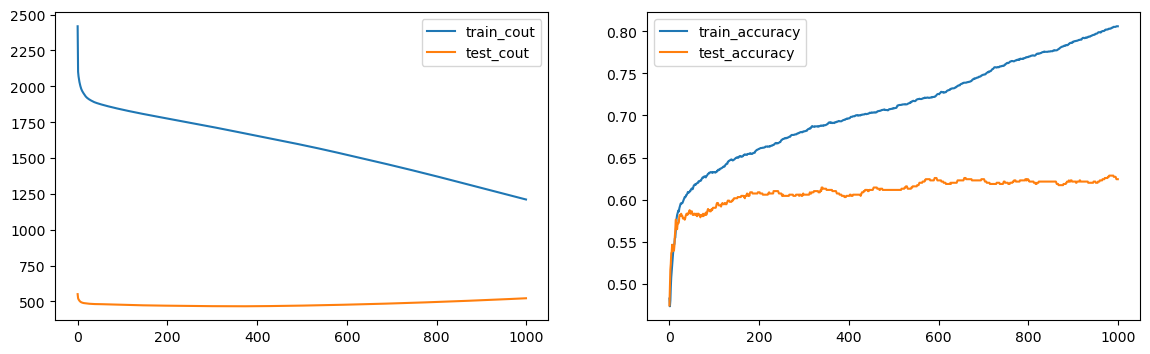

In [93]:
# Appel de la fonction et affichage des courbes de coût et d'exactitude pour l'entraînement et le test

print(x_train_reshape.shape)  # retourne (4096, 2840)
print(y_train.shape)  # retourne (1, 2840)
print(x_test_reshape.shape)  # retourne (4096, 708)
print(y_test.shape)  # retourne (1, 708)

parametres1 = neural_network(x_train_reshape, y_train, x_test_reshape, y_test)

Le score de prédiction pour le testset et le trainset

In [94]:
# Obtenez les prédictions pour le trainset et le testset
y_pred_train = predict(x_train_reshape, parametres1)
y_pred_test = predict(x_test_reshape, parametres1)

# Calculez l'accuracy_score pour le trainset et le testset
accuracy_train = accuracy_score(y_train.flatten(), y_pred_train.flatten())
accuracy_test = accuracy_score(y_test.flatten(), y_pred_test.flatten())

# Calculez le taux de réussite en pourcentage
success_rate_train = accuracy_train * 100
success_rate_test = accuracy_test * 100

print("Taux de réussite pour le trainset :", success_rate_train, "%")
print("Taux de réussite pour le testset :", success_rate_test, "%")
#76.93661971830986 %
#62.28813559322034 %

Taux de réussite pour le trainset : 80.59859154929578 %
Taux de réussite pour le testset : 62.42937853107344 %


Voir si l'image est une tulipe ou une rose

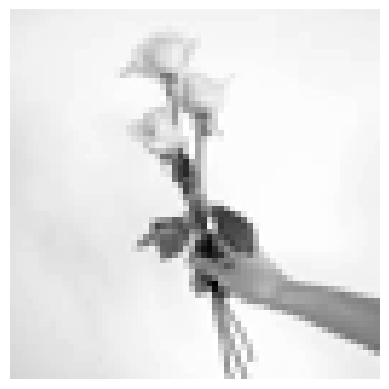

Tulipe [[0.37067712]]


In [95]:
def predict_single_image(image_path, parametres, image_size=(64, 64)):
    img = Image.open(image_path)
    img = img.convert('L')  # Convertir en niveaux de gris si ce n'est pas déjà fait
    img = img.resize(image_size)
    img_array = np.array(img).reshape(1, -1) / 255.0

    prediction = forward_propagation(img_array.T, parametres)['A4']

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

    if prediction >= 0.5:
        print("Rose", prediction)
    else:
        print("Tulipe", prediction)


image_path_to_predict = '../donnees_basique/rose1.jpg'
predict_single_image(image_path_to_predict, parametres1)

Reconnaitre toutes les images d'un répertoire

In [112]:
import os

def predict_single_image(image_path, parametres, image_size=(64, 64)):
    img = Image.open(image_path)
    img = img.convert('L')  # Convertir en niveaux de gris si ce n'est pas déjà fait
    img = img.resize(image_size)
    img_array = np.array(img).reshape(1, -1) / 255.0

    prediction = forward_propagation(img_array.T, parametres)['A4']

    if prediction >= 0.5:
        return ("Rose",prediction)
    else:
        return ("Tulipe",prediction)

def predict_images_in_directory(directory_path, parametres):
    count_rose = 0
    count_tulipe = 0
    for filename in os.listdir(directory_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            image_path = os.path.join(directory_path, filename)
            prediction, score = predict_single_image(image_path, parametres)
            if prediction == "Rose":
                count_rose += 1
            else:
                count_tulipe += 1
            print(f"{filename}: {prediction}, Score: {score}")

    print(f"Nombre de Roses: {count_rose}")
    print(f"Nombre de Tulipes: {count_tulipe}")

# Spécifiez le chemin du répertoire contenant les images à tester
directory_path_to_test = '../donnees_basique/ImagePredire/'

# Utilisez la fonction pour prédire les classes pour toutes les images du répertoire
predict_images_in_directory(directory_path_to_test, parametres1)

rose1.jpg: Tulipe, Score: [[0.37067712]]
rose10.jpg: Tulipe, Score: [[0.1707524]]
rose11.jpg: Tulipe, Score: [[0.45718424]]
rose13.jpg: Tulipe, Score: [[0.06700411]]
rose2.jpg: Tulipe, Score: [[0.42487107]]
rose3.jpg: Rose, Score: [[0.75465432]]
rose4.jpg: Rose, Score: [[0.84483577]]
rose6.jpg: Tulipe, Score: [[0.07523658]]
rose7.jpg: Tulipe, Score: [[0.22062425]]
rose8.jpg: Tulipe, Score: [[0.12848968]]
rose9.jpg: Tulipe, Score: [[0.45386443]]
Nombre de Roses: 2
Nombre de Tulipes: 9


Matrice de confusion

In [97]:
from sklearn.metrics import confusion_matrix
import itertools
y_pred=predict(x_test_reshape,parametres1)
cm=confusion_matrix(y_test,y_pred)
cm_plot_labels=['rose','tulipe']
def plot_confusion_matrix(cm,classes,normalize=False,title='Matrice de confusion',cmap=plt.cm.Blues):
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    print("Matrice de confusion normalisée")
  else:
    print("Matrice de confusion non normalisée")

  print(cm)
  thresh=cm.max()/2.
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,cm[i,j],
              horizontalalignment="center",
              color="white" if cm[i,j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('Réalité')
  plt.xlabel('Prédiction')
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Matrice de confusion sur données de test')

#Création du rapport de classification

from sklearn.metrics import classification_report
target_names=['roses','tulipes']
print(classification_report(y_test,y_pred,target_names=target_names))

ValueError: multilabel-indicator is not supported

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Convertir les étiquettes en binaire
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Calculer la probabilité de chaque classe pour chaque échantillon
# (Assurez-vous que y_pred_test contient les probabilités pour chaque classe)
y_pred_prob = forward_propagation(x_test_reshape, parametres1)['A3']

# Calculer la précision et le rappel pour chaque classe
precision = dict()
recall = dict()
for i in range(y_test_bin.shape[1]):  # Boucle sur chaque classe
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall[i], precision[i], label='Class {}'.format(i))

plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe Precision-Recall pour chaque classe')
plt.legend()
plt.show()